In [1]:
import boa
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Setup

Generate admin and fee receiver addresses (shared between old and new versions):

In [2]:
admin = boa.env.generate_address()
fee_receiver = boa.env.generate_address()
trader = boa.env.generate_address()
zero_address = boa.eval("empty(address)")
print(admin, fee_receiver, trader)

0xd13f0Bd22AFF8176761AEFBfC052a7490bDe268E 0xA73d7cddCf77c00827459f986bf828999B58C6Fe 0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B


Generate coins and coin holders for trading ...

In [3]:
coin_a = boa.load("../../contracts/mocks/ERC20Mock.vy", "coin_a", "coin_a", 18)
coin_b = boa.load("../../contracts/mocks/ERC20Mock.vy", "coin_b", "coin_b", 18)

coin_a._mint_for_testing(trader, 10**50, sender=trader)
coin_b._mint_for_testing(trader, 10**50, sender=trader)
print(coin_a, coin_b)

<../../contracts/mocks/ERC20Mock.vy at 0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9, compiled with vyper-0.3.10+9136169>
<storage: name=coin_a                          , symbol=coin_a                          , decimals=18, balanceOf={'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': 100000000000000000000000000000000000000000000000000}, allowances={}, totalSupply=100000000000000000000000000000000000000000000000000> <../../contracts/mocks/ERC20Mock.vy at 0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b, compiled with vyper-0.3.10+9136169>
<storage: name=coin_b                          , symbol=coin_b                          , decimals=18, balanceOf={'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': 100000000000000000000000000000000000000000000000000}, allowances={}, totalSupply=100000000000000000000000000000000000000000000000000>


Pool parameters:

In [4]:
A = 400000
gamma = 145000000000000
mid_fee = 26000000
out_fee = 45000000
allowed_extra_profit = 2000000000000
fee_gamma = 230000000000000
adjustment_step = 146000000000000
ma_time = 600
xcp_ma_time = 1800 * 24
initial_price = 10**18  # 1:1 at the start
admin_fee = 5 * 10**9

Instantiate contracts for factory:

In [5]:
old_swap_implementation = boa.load(
    "../../contracts/old/CurveCryptoSwap2ETH.vy", 
    boa.env.generate_address()  # use some random address as weth
)
old_math = boa.load("../../contracts/old/CurveCryptoSwap2Math.vy")
old_token = boa.load("../../contracts/old/CurveCryptoLPToken.vy")

with boa.env.prank(admin):
    old_factory = boa.load(
        "../../contracts/old/CurveCryptoFactory.vy",
        fee_receiver,
        old_swap_implementation,
        old_token,
        zero_address,
        zero_address
    )

old_swap = old_factory.deploy_pool(
    "old", "old", [coin_a.address, coin_b.address],
    A, gamma, mid_fee, out_fee, allowed_extra_profit, fee_gamma, 
    adjustment_step, admin_fee, ma_time, initial_price
)
old_swap = boa.load_partial("../../contracts/old/CurveCryptoSwap2ETH.vy").at(old_swap)
old_swap_token = boa.load_partial("../../contracts/mocks/ERC20Mock.vy").at(old_swap.token())
old_swap, old_swap_token

(<../../contracts/old/CurveCryptoSwap2ETH.vy at 0x5a0c986Eb1fED63bccD967298f5A87739951722E, compiled with vyper-0.3.10+9136169>
 <storage: token=0x5Bac22268eecccDF2fa09D03eC0D0fDbA2848ba2, coins=['0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9', '0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b'], price_scale=1000000000000000000, _price_oracle=1000000000000000000, last_prices=1000000000000000000, last_prices_timestamp=1704735410, initial_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma_time=0, allowed_extra_profit=2000000000000, future_allowed_extra_profit=0, fee_gamma=230000000000000, future_fee_gamma=0, adjustment_step=146000000000000, future_adjustment_step=0, ma_half_time=600, future_ma_half_time=0, mid_fee=26000000, out_fee=45000000, admin_fee=5000000000, future_mid_fee=0, future_out_fee=0, future_admin_fee=0, balances=[0, 0], D=0, factory=0xC6Acb7D16D51f72eAA659668F30A40d87E2E0551, xc

In [6]:
ng_swap_implementation = boa.load_partial("../../contracts/main/CurveTwocryptoOptimized.vy")
ng_math = boa.load("../../contracts/main/CurveCryptoMathOptimized2.vy")
ng_views = boa.load("../../contracts/main/CurveCryptoViews2Optimized.vy")
with boa.env.prank(admin):
    ng_factory = boa.load("../../contracts/main/CurveTwocryptoFactory.vy")
    ng_factory.initialise_ownership(fee_receiver, admin)

    ng_factory.set_pool_implementation(ng_swap_implementation.deploy_as_blueprint().address, 0)
    ng_factory.set_gauge_implementation(zero_address)
    ng_factory.set_views_implementation(ng_views.address)
    ng_factory.set_math_implementation(ng_math.address)

ng_swap = ng_factory.deploy_pool(
    "ng", "ng", [coin_a.address, coin_b.address],
    0, A, gamma, mid_fee, out_fee, fee_gamma, allowed_extra_profit, adjustment_step, int(ma_time/0.693), initial_price
)
ng_swap = ng_swap_implementation.at(ng_swap)
ng_swap

<../../contracts/main/CurveTwocryptoOptimized.vy at 0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=0, last_prices=1000000000000000000, last_timestamp=580091400288736469097005931383784428983115592370, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[0, 0], D=0, xcp_profit=0, xcp_profit_a=1000000000000000000, virtual_price=0, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={}, allowance={}, totalSupply=0, nonces={}>

Grant approvals etc.

In [7]:
with boa.env.prank(trader):
    for coin in [coin_a, coin_b]:
        for pool in [old_swap, ng_swap]:
            coin.approve(pool, 2**256-1)

print(coin_a._storage.allowances.get())
print(coin_b._storage.allowances.get())

{'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': {'0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF': 115792089237316195423570985008687907853269984665640564039457584007913129639935, '0x5a0c986Eb1fED63bccD967298f5A87739951722E': 115792089237316195423570985008687907853269984665640564039457584007913129639935}}
{'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': {'0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF': 115792089237316195423570985008687907853269984665640564039457584007913129639935, '0x5a0c986Eb1fED63bccD967298f5A87739951722E': 115792089237316195423570985008687907853269984665640564039457584007913129639935}}


Add liquidity:

In [8]:
def _get_deposit_amounts(amount_per_token_usd, initial_prices, coins):

    precisions = [10 ** coin.decimals() for coin in coins]

    deposit_amounts = [
        amount_per_token_usd * precision * 10**18 // price
        for price, precision in zip(initial_prices, precisions)
    ]
    return deposit_amounts

deposit_amounts = _get_deposit_amounts(10**8, [10**18, initial_price], [coin_a, coin_b])
deposit_amounts

[100000000000000000000000000, 100000000000000000000000000]

In [9]:
if ng_swap.totalSupply() == 0:
    lp_tokens_ng = ng_swap.add_liquidity(deposit_amounts, 0, sender=trader)
if old_swap_token.totalSupply() == 0:
    lp_tokens_old = old_swap.add_liquidity(deposit_amounts, 0, sender=trader)
    
lp_tokens_ng - lp_tokens_old

0

In [10]:
ng_swap

<../../contracts/main/CurveTwocryptoOptimized.vy at 0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=100000000000000000000000000, last_prices=1000000000000000000, last_timestamp=580091400288736469097005931383784428983115592370, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[100000000000000000000000000, 100000000000000000000000000], D=200000000000000000000000000, xcp_profit=1000000000000000000, xcp_profit_a=1000000000000000000, virtual_price=1000000000000000000, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={'0x1fb0aF0

In [11]:
old_swap

<../../contracts/old/CurveCryptoSwap2ETH.vy at 0x5a0c986Eb1fED63bccD967298f5A87739951722E, compiled with vyper-0.3.10+9136169>
<storage: token=0x5Bac22268eecccDF2fa09D03eC0D0fDbA2848ba2, coins=['0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9', '0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b'], price_scale=1000000000000000000, _price_oracle=1000000000000000000, last_prices=1000000000000000000, last_prices_timestamp=1704735410, initial_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma_time=0, allowed_extra_profit=2000000000000, future_allowed_extra_profit=0, fee_gamma=230000000000000, future_fee_gamma=0, adjustment_step=146000000000000, future_adjustment_step=0, ma_half_time=600, future_ma_half_time=0, mid_fee=26000000, out_fee=45000000, admin_fee=5000000000, future_mid_fee=0, future_out_fee=0, future_admin_fee=0, balances=[100000000000000000000000000, 100000000000000000000000000], D=2000000

## Compare trades

In [12]:
num_trades = 500
data = {
    "timestamp": [],
    "i": [],
    "in_amt": [],
    "old_swap_out_amt": [],
    "ng_swap_out_amt": [],
    "old_swap_balances_a": [],
    "old_swap_balances_b": [],
    "ng_swap_balances_a": [],
    "ng_swap_balances_b": [],
    "old_swap_xcp_profit": [],
    "ng_swap_xcp_profit": [],
    "old_swap_D": [],
    "ng_swap_D": [],
    "old_swap_lp_price": [],
    "ng_swap_lp_price": [],
    "old_swap_virtual_price": [],
    "ng_swap_virtual_price": [],
    "old_swap_price_scale": [],
    "old_swap_price_oracle": [],
    "ng_swap_price_scale": [],
    "ng_swap_price_oracle": [],
    "ng_swap_xcp_oracle": [],
    "old_swap_last_price": [],
    "ng_swap_last_price": [],
    "ng_fee_receiver_balances_a": [],
    "ng_fee_receiver_balances_b": [],
    "old_fee_receiver_balances_a": [],
    "old_fee_receiver_balances_b": [],
}

In [13]:
old_swap.adjustment_step()

146000000000000

In [14]:
ng_swap.adjustment_step()

146000000000000

In [15]:
coin_precisions = {0: 10**coin_a.decimals(), 1: 10**coin_b.decimals()}

for _ in range(num_trades):
    
    i = random.randint(0, 1)
    trade_amount = random.randint(1, 10**4 * coin_precisions[i])
    
    out_old = old_swap.exchange(i, 1-i, trade_amount, 0, sender=trader)
    out_ng = ng_swap.exchange(i, 1-i, trade_amount, 0, sender=trader)
    
    # store data:
    data["timestamp"].append(boa.env.vm.state.timestamp)
    
    data["old_swap_out_amt"].append(out_old / coin_precisions[1-i])
    data["ng_swap_out_amt"].append(out_ng / coin_precisions[1-1])
    data["i"].append(i)
    data["in_amt"].append(trade_amount / coin_precisions[i])
    
    balances = old_swap._storage.balances.get()
    data["old_swap_balances_a"].append(balances[0] / coin_precisions[0])
    data["old_swap_balances_b"].append(balances[1] / coin_precisions[1])
    data["old_swap_D"].append(old_swap._storage.D.get() / 1e18)
    data["old_swap_xcp_profit"].append(old_swap._storage.xcp_profit.get() / 1e18)
    data["old_swap_price_oracle"].append(old_swap.price_oracle() / 1e18)
    data["old_swap_price_scale"].append(old_swap.price_scale() / 1e18)
    data["old_swap_last_price"].append(old_swap.last_prices() / 1e18)
    data["old_swap_virtual_price"].append(old_swap.virtual_price() / 1e18)
    data["old_swap_lp_price"].append(old_swap.lp_price() / 1e18)
    
    # calc fees collected so far:
    admin_frac_old = (old_swap_token.balanceOf(fee_receiver) / old_swap_token._storage.totalSupply.get())
    data["old_fee_receiver_balances_a"] = int(admin_frac_old * balances[0] / coin_precisions[0])
    data["old_fee_receiver_balances_b"] = int(admin_frac_old * balances[1] / coin_precisions[1])
    
    balances = ng_swap._storage.balances.get()
    data["ng_swap_balances_a"].append(balances[0] / coin_precisions[0])
    data["ng_swap_balances_b"].append(balances[1] / coin_precisions[1])
    data["ng_swap_D"].append(ng_swap._storage.D.get() / 1e18)
    data["ng_swap_xcp_profit"].append(ng_swap._storage.xcp_profit.get() / 1e18)
    data["ng_swap_price_oracle"].append(ng_swap.price_oracle() / 1e18)
    data["ng_swap_xcp_oracle"].append(ng_swap.xcp_oracle() / 1e18)
    data["ng_swap_price_scale"].append(ng_swap.price_scale() / 1e18)
    data["ng_swap_last_price"].append(ng_swap.last_prices() / 1e18)
    data["ng_swap_virtual_price"].append(ng_swap.virtual_price() / 1e18)
    data["ng_swap_lp_price"].append(ng_swap.lp_price() / 1e18)
    
    with boa.env.anchor():
        ng_swap.remove_liquidity_one_coin(10**18, i, 0, sender=trader)
        data["ng_fee_receiver_balances_a"].append(coin_a.balanceOf(fee_receiver) / coin_precisions[0])
        data["ng_fee_receiver_balances_b"].append(coin_b.balanceOf(fee_receiver) / coin_precisions[1])
    
    boa.env.time_travel(random.randint(1, 1000))
    

In [16]:
df = pd.DataFrame(data)
df.set_index("timestamp", inplace=True)
df

,i,in_amt,old_swap_out_amt,ng_swap_out_amt,old_swap_balances_a,old_swap_balances_b,ng_swap_balances_a,ng_swap_balances_b,old_swap_xcp_profit,ng_swap_xcp_profit,...,old_swap_price_oracle,ng_swap_price_scale,ng_swap_price_oracle,ng_swap_xcp_oracle,old_swap_last_price,ng_swap_last_price,ng_fee_receiver_balances_a,ng_fee_receiver_balances_b,old_fee_receiver_balances_a,old_fee_receiver_balances_b
timestamp,,,,,,,,,,,,,,,,,,,,,
1704735410,0,7554.489506,7534.820370,7534.820370,1.000076e+08,9.999247e+07,1.000076e+08,9.999247e+07,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000e+08,1.002610,1.000007,2.455439,2.455068,801,803
1704736341,1,8657.208767,8634.726465,8634.726465,9.999892e+07,1.000011e+08,9.999892e+07,1.000011e+08,1.000000,1.000000,...,1.001720,1.000000,1.000005,1.000000e+08,0.997403,0.999999,5.268800,5.268916,801,803
1704736662,0,8784.204296,8761.337476,8761.337476,1.000077e+08,9.999236e+07,1.000077e+08,9.999236e+07,1.000000,1.000000,...,1.000382,1.000000,1.000003,1.000000e+08,1.002610,1.000007,8.124402,8.123156,801,803
1704736701,0,3938.198833,3927.923004,3927.923004,1.000116e+08,9.998843e+07,1.000116e+08,9.998843e+07,1.000000,1.000000,...,1.000481,1.000000,1.000003,1.000000e+08,1.002616,1.000011,9.404835,9.402652,801,803
1704736978,1,3335.966415,3327.324210,3327.324210,1.000083e+08,9.999177e+07,1.000083e+08,9.999177e+07,1.000000,1.000000,...,1.001065,1.000000,1.000005,1.000000e+08,0.997409,1.000008,10.488830,10.487095,801,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704983913,1,2804.113871,2796.082512,2794.864449,9.986675e+07,1.001400e+08,9.986405e+07,1.001426e+08,1.000017,1.000033,...,1.001228,0.999416,0.999312,1.000025e+08,0.997136,0.999308,829.765212,832.079594,801,803
1704984253,0,3741.081216,3731.275098,3733.895562,9.987050e+07,1.001362e+08,9.986779e+07,1.001389e+08,1.000017,1.000033,...,0.999899,0.999416,0.999310,1.000025e+08,1.002628,0.999312,831.015221,833.270803,801,803
1704984599,1,1479.647990,1475.584619,1474.770384,9.986902e+07,1.001377e+08,9.986632e+07,1.001403e+08,1.000017,1.000033,...,1.000798,0.999416,0.999311,1.000025e+08,0.997254,0.999311,831.484759,833.766247,801,803


Comparisons:

1. Differences in outputs
2. Differences Price oracle updates
3. Differences in price scale updates
4. Differences in abs(price_scale - price_oracle)
5. Differences in pool balances
6. Differences in D
7. Differences in xcp profit
8. Differences in admin balances

In [53]:
def print_diff(loc):
    
    calc_diff = lambda x: print(f"{x}: " + str(df.loc[loc, f"old_swap_{x}"] - df.loc[loc, f"ng_swap_{x}"]))
    i = df.loc[loc, "i"]
    print(f"Traded {i} > {1-i}, in amount: {df.loc[loc, 'in_amt']}")
    print("Difference between old_swap and ng_swap:")
    
    calc_diff("out_amt")
    calc_diff("balances_a")
    calc_diff("balances_b")
    calc_diff("D")
    calc_diff("xcp_profit")
    calc_diff("virtual_price")
    calc_diff("last_price")
    calc_diff("price_oracle")
    calc_diff("price_scale")
    calc_diff("lp_price")

Text(0.5, 0.98, 'blue=old, orange=ng')

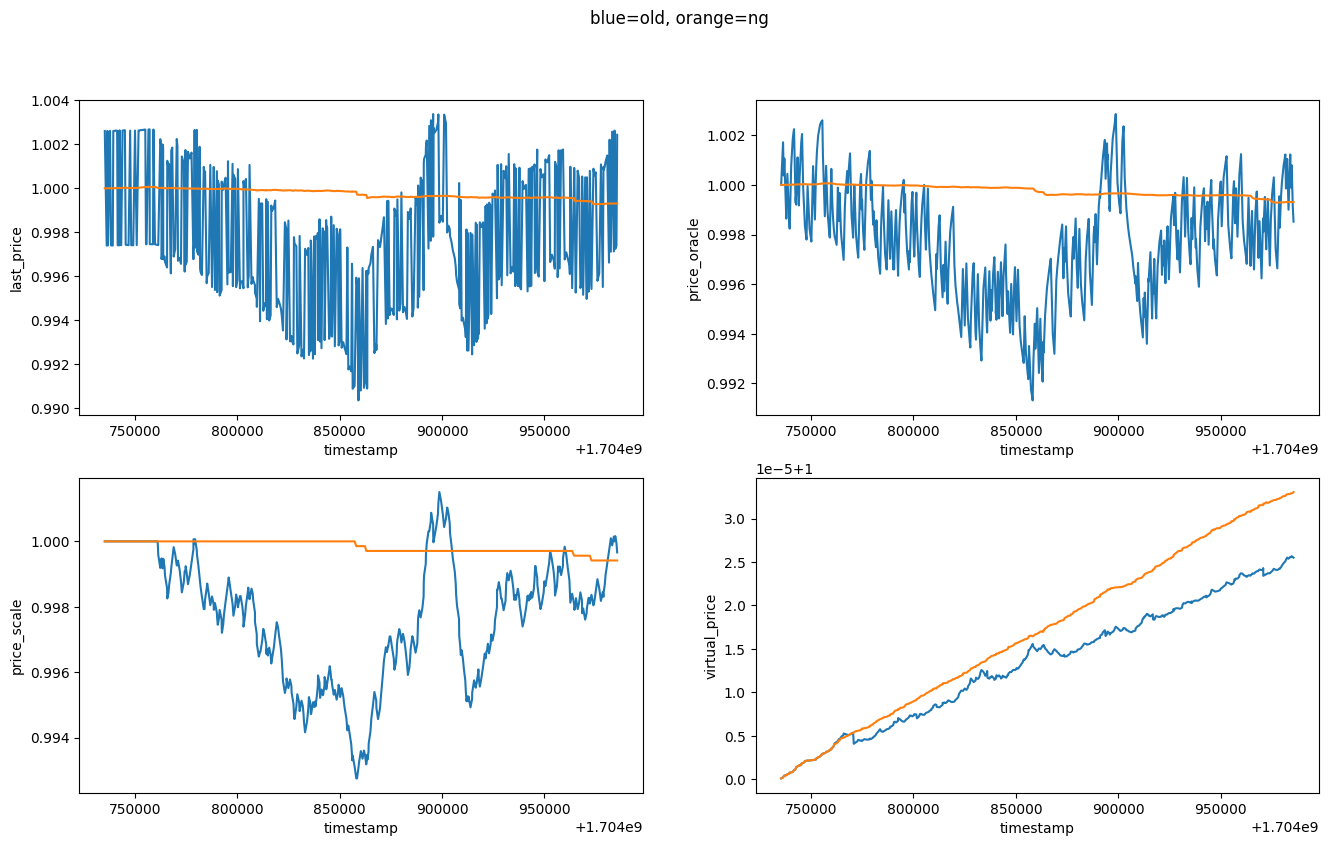

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
df[["old_swap_last_price", "ng_swap_last_price"]].plot(ax=ax[0][0], legend=False, ylabel="last_price")
df[["old_swap_price_oracle", "ng_swap_price_oracle"]].plot(ax=ax[0][1], legend=False, ylabel="price_oracle")
df[["old_swap_price_scale", "ng_swap_price_scale"]].plot(ax=ax[1][0], legend=False, ylabel="price_scale")
df[["old_swap_virtual_price", "ng_swap_virtual_price"]].plot(ax=ax[1][1], legend=False, ylabel="virtual_price")

fig.suptitle("blue=old, orange=ng")

In [18]:
df.ng_swap_price_oracle

timestamp
1704735410    1.000000
1704736341    1.000005
1704736662    1.000003
1704736701    1.000003
1704736978    1.000005
                ...   
1704983913    0.999312
1704984253    0.999310
1704984599    0.999311
1704985167    0.999311
1704985524    0.999310
Name: ng_swap_price_oracle, Length: 500, dtype: float64

It seems ng is more 'stable' ? let's compare scale deltas

<Axes: xlabel='timestamp'>

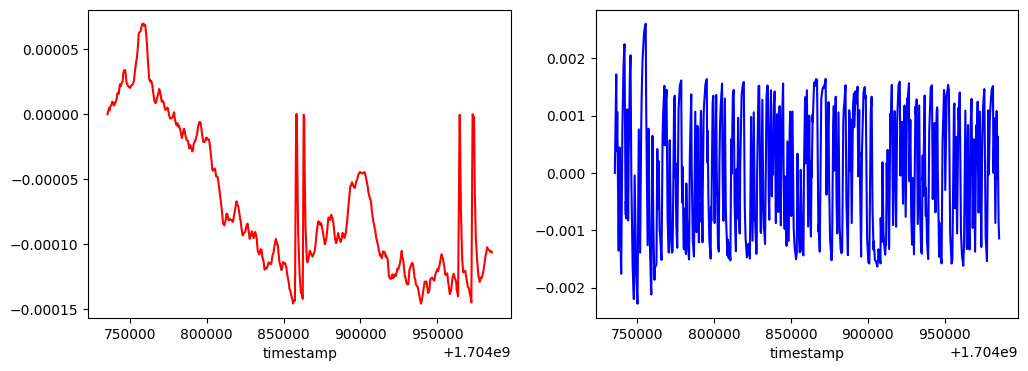

In [57]:
ng_swap_scale_delta = df.ng_swap_price_oracle - df.ng_swap_price_scale
old_swap_scale_delta = df.old_swap_price_oracle - df.old_swap_price_scale

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ng_swap_scale_delta.plot(color='r', ax=ax[0])
old_swap_scale_delta.plot(color='b', ax=ax[1])


What's happening at these random spikes?

<Axes: xlabel='timestamp', ylabel='virtual price'>

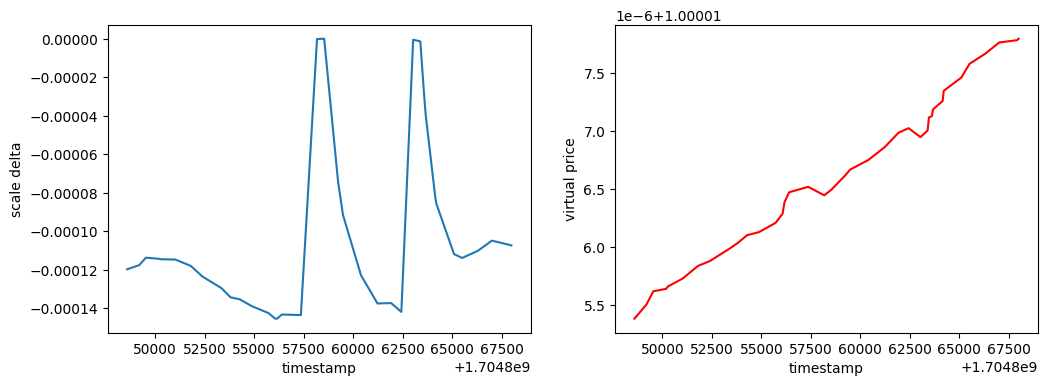

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ng_swap_scale_delta.loc[1704848253:1704868253].plot(ax=ax[0], ylabel="scale delta")
df.ng_swap_virtual_price.loc[1704848253:1704868253].plot(color='r', ax=ax[1], ylabel="virtual price")

In [69]:
ng_swap_scale_delta.loc[1704848253:1704868253]

timestamp
1704848588   -1.197339e-04
1704849197   -1.175787e-04
1704849541   -1.136724e-04
1704850188   -1.142611e-04
1704850287   -1.145028e-04
1704851020   -1.146568e-04
1704851801   -1.179447e-04
1704852391   -1.234748e-04
1704853359   -1.295768e-04
1704853809   -1.342903e-04
1704854279   -1.353363e-04
1704854881   -1.388689e-04
1704855720   -1.424393e-04
1704856070   -1.454184e-04
1704856169   -1.453424e-04
1704856402   -1.432374e-04
1704857363   -1.435112e-04
1704858178   -2.934678e-08
1704858540    1.221071e-07
1704859240   -7.398852e-05
1704859489   -9.144793e-05
1704860397   -1.227698e-04
1704861233   -1.374904e-04
1704861927   -1.373045e-04
1704862437   -1.418824e-04
1704863034   -3.956743e-07
1704863397   -1.276770e-06
1704863463   -1.118036e-05
1704863610   -3.217236e-05
1704863673   -4.006966e-05
1704864157   -8.271772e-05
1704864210   -8.573880e-05
1704865098   -1.118291e-04
1704865513   -1.138370e-04
1704866310   -1.100745e-04
1704867010   -1.048382e-04
1704867909   -1.07

These two dips coincide with an aggressive rebalancing where the price scale gets very very close to the price oracle and then drifts off again. Looks fine.

<Axes: xlabel='timestamp'>

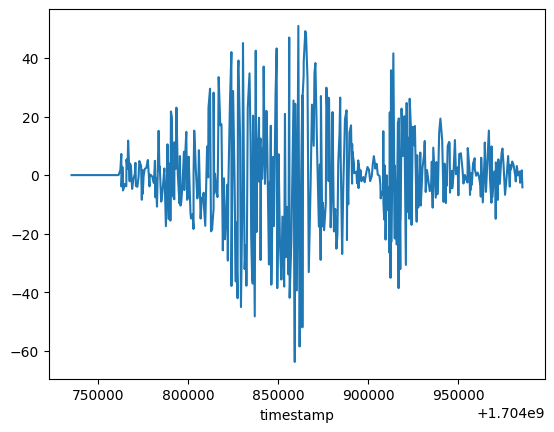

In [20]:
diff_output = (df.old_swap_out_amt).astype(float) - (df.ng_swap_out_amt).astype(float)
diff_output.plot()

It seems the amms behave similarly until a moment and then they deviate quite a bit. It must be due to rebalancing ...

<Axes: xlabel='timestamp'>

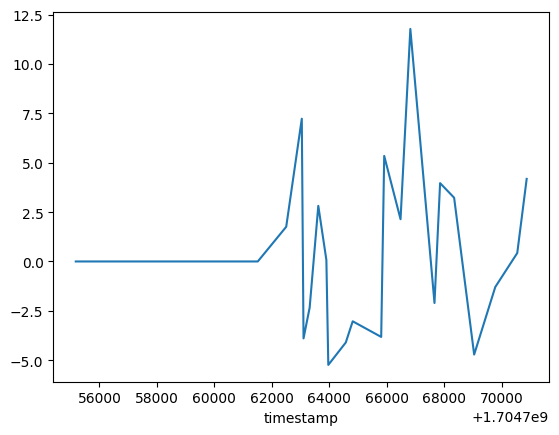

In [73]:
diff_output.loc[1704755000:1704771032].plot()

<Axes: xlabel='timestamp'>

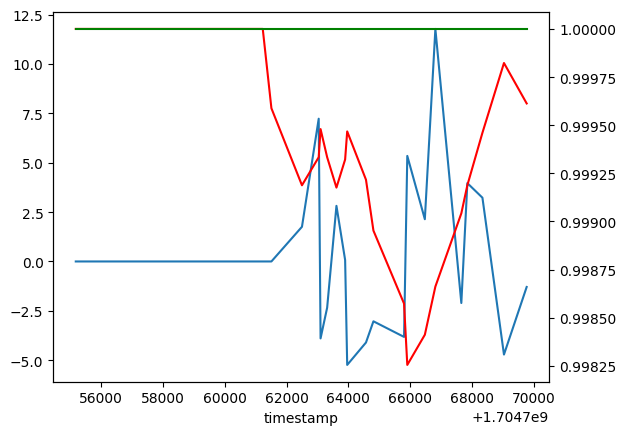

In [52]:
fig, ax = plt.subplots(1, 1)
diff_output.loc[1704755000:1704770000].plot(ax=ax)

ax2 = ax.twinx()
df.old_swap_price_scale.loc[1704755000:1704770000].plot(color='r', ax=ax2)
df.ng_swap_price_scale.loc[1704755000:1704770000].plot(color='g', ax=ax2)

The old implementation's price_scale changes whereas ng implementation's price scale does not. which is why we see such a difference in output swap amounts between the two implementations. This is not to say that the price scale in ng implementation does not change whatsoever: it does but not that often

In [58]:
df.to_csv("./impl_comparison_data.csv")